In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pyspark.sql.types import StructType, StructField, LongType, IntegerType, StringType
from pyspark.sql.functions import mean as _mean, col


%matplotlib inline

# EDA

In [3]:
app_name = "w261_final_harith"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .getOrCreate()
sc = spark.sparkContext

In [4]:
test_tiny_rdd = sc.textFile('gs://w261-elrufaie/test.tiny.csv')
train_tiny_rdd = sc.textFile('gs://w261-elrufaie/test.tiny.csv')

test_tmp_rdd = sc.textFile('gs://w261-elrufaie/test.txt')
train_tmp_rdd = sc.textFile('gs://w261-elrufaie/train.txt')

In [5]:
test_tmp_rdd.count()

6042135

In [15]:
train_tmp_rdd.count()

45840617

In [63]:
df = spark.read.csv('gs://w261-elrufaie/test.tiny.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- Label: integer (nullable = true)
 |-- I1: integer (nullable = true)
 |-- I2: integer (nullable = true)
 |-- I3: integer (nullable = true)
 |-- I4: integer (nullable = true)
 |-- I5: integer (nullable = true)
 |-- I6: integer (nullable = true)
 |-- I7: integer (nullable = true)
 |-- I8: integer (nullable = true)
 |-- I9: integer (nullable = true)
 |-- I10: integer (nullable = true)
 |-- I11: integer (nullable = true)
 |-- I12: integer (nullable = true)
 |-- I13: integer (nullable = true)
 |-- C1: string (nullable = true)
 |-- C2: string (nullable = true)
 |-- C3: string (nullable = true)
 |-- C4: string (nullable = true)
 |-- C5: string (nullable = true)
 |-- C6: string (nullable = true)
 |-- C7: string (nullable = true)
 |-- C8: string (nullable = true)
 |-- C9: string (nullable = true)
 |-- C10: string (nullable = true)
 |-- C11: string (nullable = true)
 |-- C12: string (nullable = true)
 |-- C13: string (nullable = true)
 |-- C14: string 

In [64]:
test_tiny_df = spark.read.csv('gs://w261-elrufaie/test.tiny.csv', header = True, inferSchema = True)
train_tiny_df = spark.read.csv('gs://w261-elrufaie/train.tiny.csv', header = True, inferSchema = True)

test_df = spark.read.csv('gs://w261-elrufaie/test.txt', header = True)
train_df = spark.read.csv('gs://w261-elrufaie/train.txt', header = True)

In [43]:
pd.DataFrame(train_tiny_df.take(5), columns=train_tiny_df.columns)

,Id,Label,I1,I2,I3,I4,I5,I6,I7,I8,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,10000000,0,1,1,5,0,1382,4,15,2,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,None,3a171ecb,c5c50484,e8b83407,9727dd16
1,10000001,0,2,0,44,1,102,8,2,2,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,None,3a171ecb,43f13e8b,e8b83407,731c3655
2,10000002,0,2,0,1,14,767,89,4,2,...,8efede7f,3412118d,None,None,e587c466,ad3062eb,3a171ecb,3b183c5c,None,None
3,10000003,0,None,893,None,None,4392,None,0,0,...,1e88c74f,74ef3502,None,None,6b3a5ca6,None,3a171ecb,9117a34a,None,None
4,10000004,0,3,-1,None,0,2,0,3,0,...,1e88c74f,26b3c7a7,None,None,21c9516a,None,32c7478e,b34f3128,None,None


In [185]:
train_tmp_rdd.take(2)

[u'0\t1\t1\t5\t0\t1382\t4\t15\t2\t181\t1\t2\t\t2\t68fd1e64\t80e26c9b\tfb936136\t7b4723c4\t25c83c98\t7e0ccccf\tde7995b8\t1f89b562\ta73ee510\ta8cd5504\tb2cb9c98\t37c9c164\t2824a5f6\t1adce6ef\t8ba8b39a\t891b62e7\te5ba7672\tf54016b9\t21ddcdc9\tb1252a9d\t07b5194c\t\t3a171ecb\tc5c50484\te8b83407\t9727dd16',
 u'0\t2\t0\t44\t1\t102\t8\t2\t2\t4\t1\t1\t\t4\t68fd1e64\tf0cf0024\t6f67f7e5\t41274cd7\t25c83c98\tfe6b92e5\t922afcc0\t0b153874\ta73ee510\t2b53e5fb\t4f1b46f3\t623049e6\td7020589\tb28479f6\te6c5b5cd\tc92f3b61\t07c540c4\tb04e4670\t21ddcdc9\t5840adea\t60f6221e\t\t3a171ecb\t43f13e8b\te8b83407\t731c3655']

Unfortunately the full test and train dataset is unlabeled. So we'll need to fix that and add a Schema to the DF. 

In [7]:
structList = [StructField('Label', StringType(), True) ] + \
             [StructField('I' + str(i), StringType(), True) for i in range(1, 14)] + \
             [StructField('C' + str(i), StringType(), True) for i in range(14,40)]

In [8]:
train_rdd = train_tmp_rdd.map(lambda x: x.encode("ascii", "ignore")) \
                 .map(lambda x: x.split('\t'))

In [9]:
train_rdd.take(2)

[['0',
  '1',
  '1',
  '5',
  '0',
  '1382',
  '4',
  '15',
  '2',
  '181',
  '1',
  '2',
  '',
  '2',
  '68fd1e64',
  '80e26c9b',
  'fb936136',
  '7b4723c4',
  '25c83c98',
  '7e0ccccf',
  'de7995b8',
  '1f89b562',
  'a73ee510',
  'a8cd5504',
  'b2cb9c98',
  '37c9c164',
  '2824a5f6',
  '1adce6ef',
  '8ba8b39a',
  '891b62e7',
  'e5ba7672',
  'f54016b9',
  '21ddcdc9',
  'b1252a9d',
  '07b5194c',
  '',
  '3a171ecb',
  'c5c50484',
  'e8b83407',
  '9727dd16'],
 ['0',
  '2',
  '0',
  '44',
  '1',
  '102',
  '8',
  '2',
  '2',
  '4',
  '1',
  '1',
  '',
  '4',
  '68fd1e64',
  'f0cf0024',
  '6f67f7e5',
  '41274cd7',
  '25c83c98',
  'fe6b92e5',
  '922afcc0',
  '0b153874',
  'a73ee510',
  '2b53e5fb',
  '4f1b46f3',
  '623049e6',
  'd7020589',
  'b28479f6',
  'e6c5b5cd',
  'c92f3b61',
  '07c540c4',
  'b04e4670',
  '21ddcdc9',
  '5840adea',
  '60f6221e',
  '',
  '3a171ecb',
  '43f13e8b',
  'e8b83407',
  '731c3655']]

In [10]:
train_df = spark.createDataFrame(train_rdd, StructType(structList))

In [11]:
train_df.printSchema()

root
 |-- Label: string (nullable = true)
 |-- I1: string (nullable = true)
 |-- I2: string (nullable = true)
 |-- I3: string (nullable = true)
 |-- I4: string (nullable = true)
 |-- I5: string (nullable = true)
 |-- I6: string (nullable = true)
 |-- I7: string (nullable = true)
 |-- I8: string (nullable = true)
 |-- I9: string (nullable = true)
 |-- I10: string (nullable = true)
 |-- I11: string (nullable = true)
 |-- I12: string (nullable = true)
 |-- I13: string (nullable = true)
 |-- C14: string (nullable = true)
 |-- C15: string (nullable = true)
 |-- C16: string (nullable = true)
 |-- C17: string (nullable = true)
 |-- C18: string (nullable = true)
 |-- C19: string (nullable = true)
 |-- C20: string (nullable = true)
 |-- C21: string (nullable = true)
 |-- C22: string (nullable = true)
 |-- C23: string (nullable = true)
 |-- C24: string (nullable = true)
 |-- C25: string (nullable = true)
 |-- C26: string (nullable = true)
 |-- C27: string (nullable = true)
 |-- C28: string (null

In [74]:
############
#### use the tiny dataset for now ###
######

train_df = train_tiny_df

In [202]:
#train_df.take(2)
#train_df.filter('Label == 1').count()


KeyboardInterrupt: 

### CTR in the training data

Let us examine the CTR in the provided sample data.. This will help us in further breakdown and analysis... 

q- get count of 0's and 1's

In [75]:
train_df.groupBy('Label').count().show()
#train_df.filter('Label == 1').count()

+-----+-----+
|Label|count|
+-----+-----+
|    1|  418|
|    0| 1581|
+-----+-----+



ratio of CTR

In [49]:
train_df.select(_mean(col('Label'))).show()

+-------------------+
|         avg(Label)|
+-------------------+
|0.20910455227613806|
+-------------------+



### Identify relationships between numerical features

In [76]:
numeric_features = train_df.columns[2:15]
categorical_features = train_df.columns[15:41]

train_tiny_df.select(numeric_features).describe().toPandas().transpose()

numeric_data = train_df.select(numeric_features).toPandas()

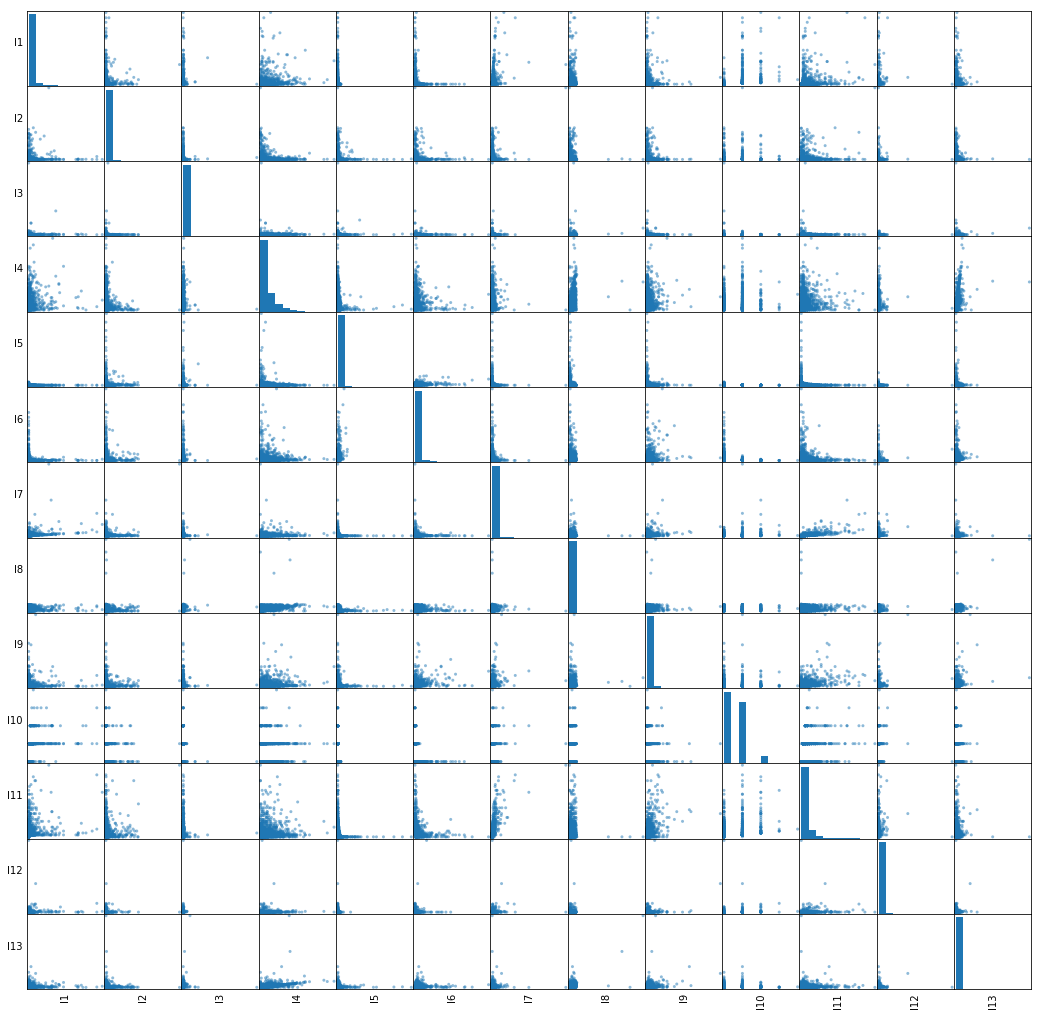

In [77]:
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(18, 18));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

### Identify a possible correlations between numerical features and CTR

In [78]:
numeric_data_with_click = train_df.select(numeric_features) \
                            .filter('Label == 1').toPandas()

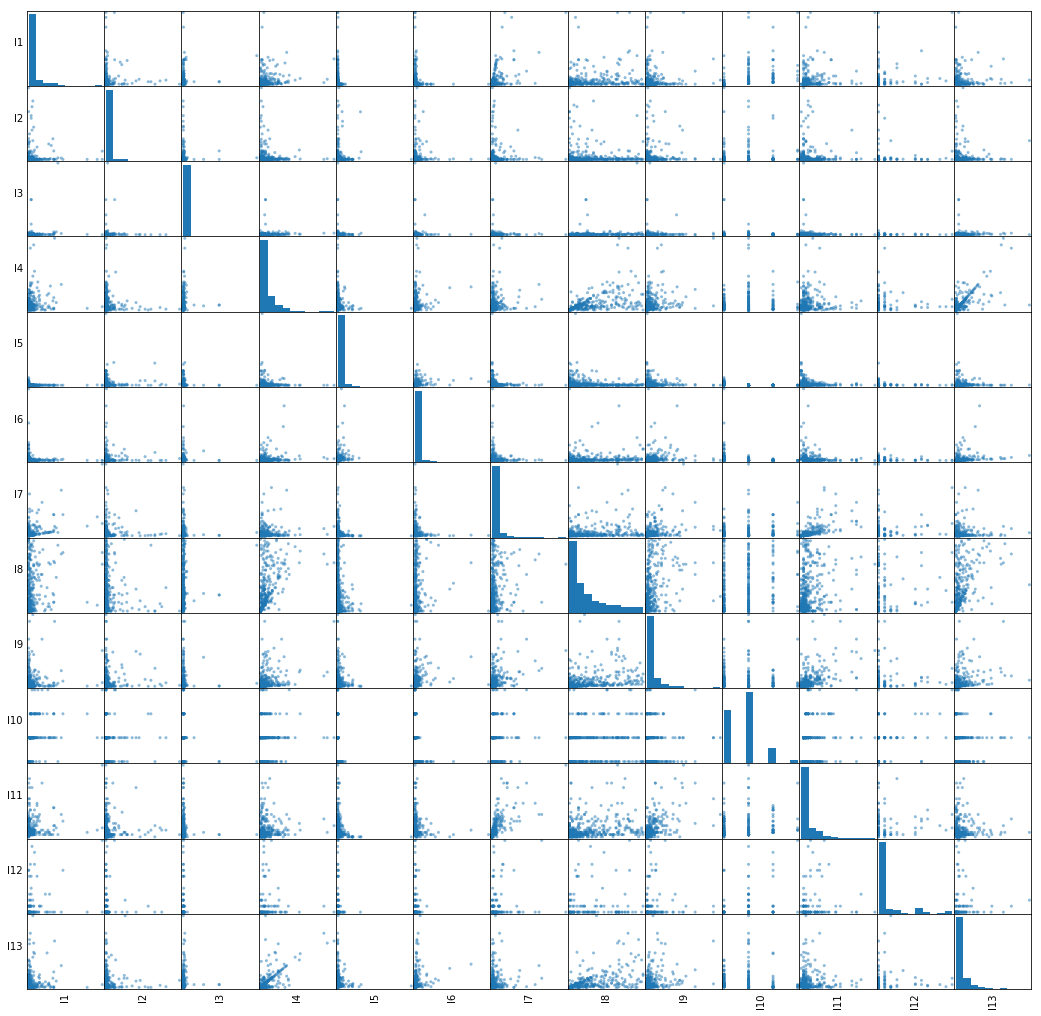

In [79]:
axs = pd.plotting.scatter_matrix(numeric_data_with_click, figsize=(18, 18));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

### Identify a possible correlations between categorical features and CTR

In order to collect useful insights from the values of categorical features, we'll need to host encode the values into 0's and 1's. 

In [ ]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler



In [ ]:
cat_data_with_click = train_df.select(categorical_features) \
                            .filter('Label == 1').toPandas()

In [101]:
axs = pd.plotting.scatter_matrix(cat_data_with_click, figsize=(18, 18));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

ValueError: num must be 1 <= num <= 0, not 1

### Explore fields in depth

In [96]:
def print_field_props(feature_name):
    train_df[[feature_name]].describe().show()

In [97]:
for feature in train_df.columns:
    print_field_props(feature)

+-------+-----------------+
|summary|               Id|
+-------+-----------------+
|  count|             1999|
|   mean|      1.0000999E7|
| stddev|577.2059135756205|
|    min|         10000000|
|    max|         10001998|
+-------+-----------------+

+-------+-------------------+
|summary|              Label|
+-------+-------------------+
|  count|               1999|
|   mean|0.20910455227613806|
| stddev| 0.4067709566641557|
|    min|                  0|
|    max|                  1|
+-------+-------------------+

+-------+------------------+
|summary|                I1|
+-------+------------------+
|  count|              1110|
|   mean|3.6963963963963966|
| stddev| 9.656064012538138|
|    min|                 0|
|    max|                95|
+-------+------------------+

+-------+-----------------+
|summary|               I2|
+-------+-----------------+
|  count|             1999|
|   mean|120.3431715857929|
| stddev|427.6375137137546|
|    min|               -2|
|    max|         

+-------+--------+
|summary|     C24|
+-------+--------+
|  count|    1933|
|   mean|Infinity|
| stddev|     NaN|
|    min|00161819|
|    max|ff09b92e|
+-------+--------+

+-------+--------+
|summary|     C25|
+-------+--------+
|  count|    1034|
|   mean|    null|
| stddev|    null|
|    min|001f3601|
|    max|fd2fe0bd|
+-------+--------+

+-------+--------+
|summary|     C26|
+-------+--------+
|  count|    1034|
|   mean|Infinity|
| stddev|     NaN|
|    min|0015d4de|
|    max|ffc123e9|
+-------+--------+



-- find/replace null values